In [1]:
import numpy as np
import cv2
import pysift
from matplotlib import pyplot as plt
import logging

img1 = cv2.imread('box.png', 0)           # queryImage
img2 = cv2.imread('box_in_scene.png', 0)  # trainImage

In [2]:
# Setting the hyperparameter
# =======================================================
# the default is on the following comment
# MIN_MATCH_COUNT = 10
# sigma=1.6
# num_intervals=3
# assumed_blur=0.5
# image_border_width=5
# =======================================================

MIN_MATCH_COUNT = 20
sigma=3.6
num_intervals=4
assumed_blur=1
image_border_width=40


# Compute SIFT keypoints and descriptors
# =======================================================
# def computeKeypointsAndDescriptors(image, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5):
kp1, des1 = pysift.computeKeypointsAndDescriptors(img1,sigma=sigma,
                                                  num_intervals=num_intervals,
                                                  assumed_blur=assumed_blur,
                                                  image_border_width=image_border_width)
kp2, des2 = pysift.computeKeypointsAndDescriptors(img2,sigma=sigma,
                                                  num_intervals=num_intervals,
                                                  assumed_blur=assumed_blur,
                                                  image_border_width=image_border_width)

In [3]:
e = kp1[0]
print(f"keypoints angle: {e.angle}")
print(f"keypoints class_id: {e.class_id:}")
print(F"keypoints octave: {e.octave}")
print(f"keypoints repsonse: {e.response}")
print(f"keypoints point: {e.pt}")
print(f"keypoints size: {e.size}")

keypoints angle: 359.58380126953125
keypoints class_id: -1
keypoints octave: 7209727
keypoints repsonse: 0.023095078766345978
keypoints point: (34.03410720825195, 126.73307037353516)
keypoints size: 5.030222415924072


In [4]:
# Initialize and use FLANN
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

### Something useful visualize self-defined function

In [5]:
def methodlst(method):
    # check the method function
    return [inst for inst in dir(method) if inst[0]!='_']


def plotPoint(newimg, kp1, kp2, good):
    # method = {"line": cv2.line(newimg, pt1, pt2, (255, 0, 0)), "point": cv2.circle(newimg, pt1, radius=2, color=(128+idx,255-idx, idx), thickness=-1)}
    for idx, m in enumerate(good):
        pt1 = (int(kp1[m.queryIdx].pt[0]), int(kp1[m.queryIdx].pt[1] + hdif))
        pt2 = (int(kp2[m.trainIdx].pt[0] + w1), int(kp2[m.trainIdx].pt[1]))
        # cv2.line(newimg, pt1, pt2, (255, 0, 0))
        idx = int(np.mod(5*idx, 254)+1)
        cv2.circle(newimg, pt1, radius=2, color=(128+idx,255-idx, idx), thickness=-1)
        cv2.circle(newimg, pt2, radius=2, color=(128+idx,255-idx,idx), thickness=-1)
    plt.figure(figsize=(20, 16))
    plt.imshow(newimg)
    plt.show()
    return None


def plotLine(newimg, kp1, kp2, good):
    for idx, m in enumerate(good):
        pt1 = (int(kp1[m.queryIdx].pt[0]), int(kp1[m.queryIdx].pt[1] + hdif))
        pt2 = (int(kp2[m.trainIdx].pt[0] + w1), int(kp2[m.trainIdx].pt[1]))
        cv2.line(newimg, pt1, pt2, (255, 0, 0))
    plt.figure(figsize=(20, 16))
    plt.imshow(newimg)
    plt.show()
    return None

### Visualize

Number of good match points : 30


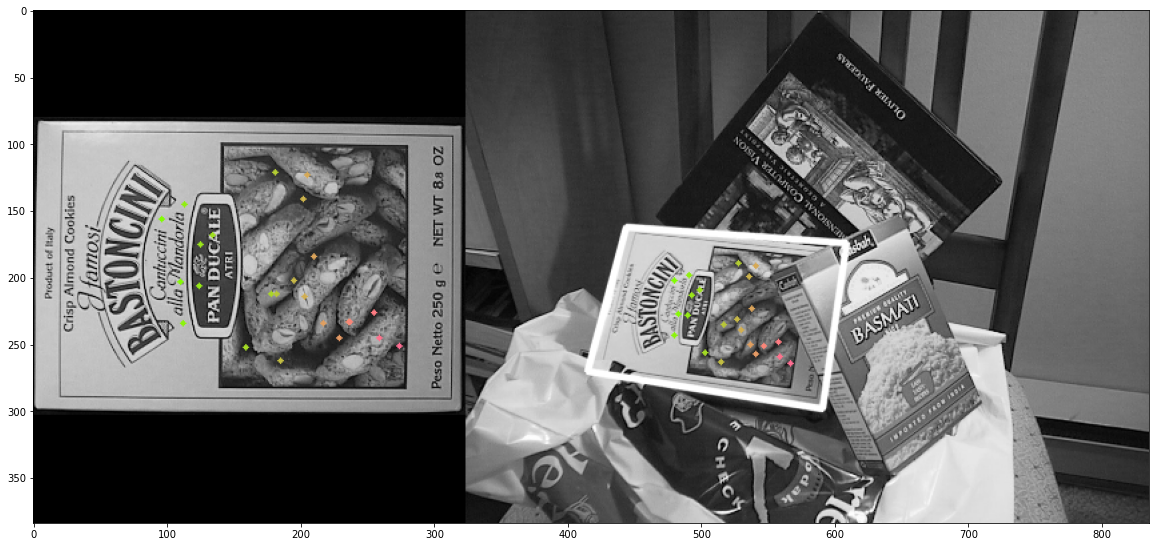

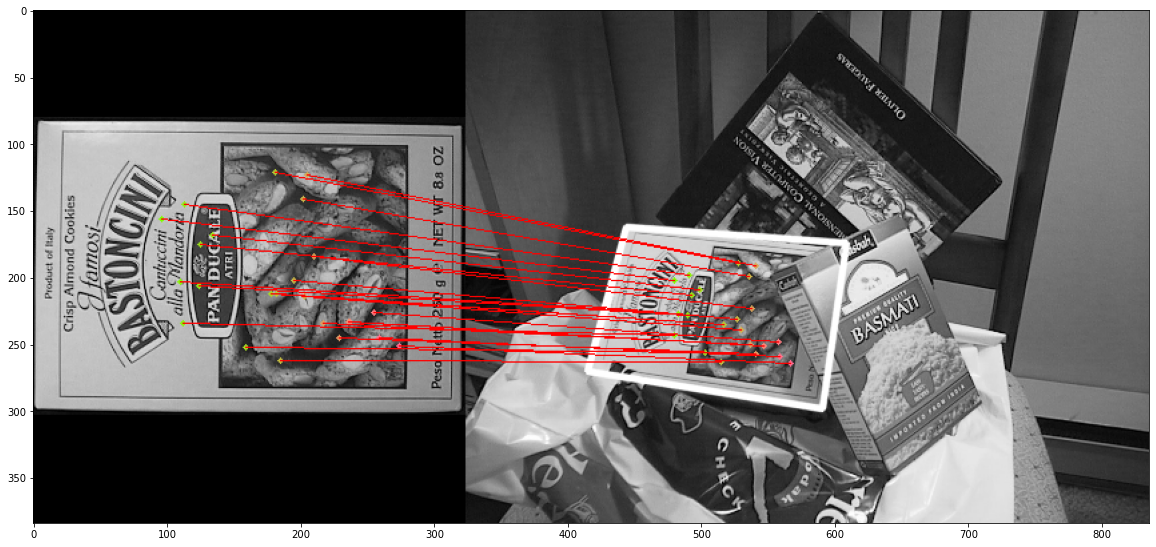

In [6]:
# Lowe's ratio test
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)
print(f"Number of good match points : {len(good)}")
        
if len(good) > MIN_MATCH_COUNT:
    # Estimate homography between template and scene
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    M = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)[0]

    # Draw detected template in scene image
    h, w = img1.shape
    pts = np.float32([[0, 0],
                      [0, h - 1],
                      [w - 1, h - 1],
                      [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)

    img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

    h1, w1 = img1.shape
    h2, w2 = img2.shape
    nWidth = w1 + w2
    nHeight = max(h1, h2)
    hdif = int((h2 - h1) / 2)
    newimg = np.zeros((nHeight, nWidth, 3), np.uint8)

    for i in range(3):
        newimg[hdif:hdif + h1, :w1, i] = img1
        newimg[:h2, w1:w1 + w2, i] = img2

    # Draw SIFT keypoint matches
    plotPoint(newimg, kp1, kp2, good)
    plotLine(newimg, kp1, kp2, good)

else:
    print("Not enough matches are found - %d/%d" % (len(good), MIN_MATCH_COUNT))

# Appendix
## Visualize each function

generateBaseImage, fix sigma, adjust blurlist
generateBaseImage, adjust sigma, fix blur


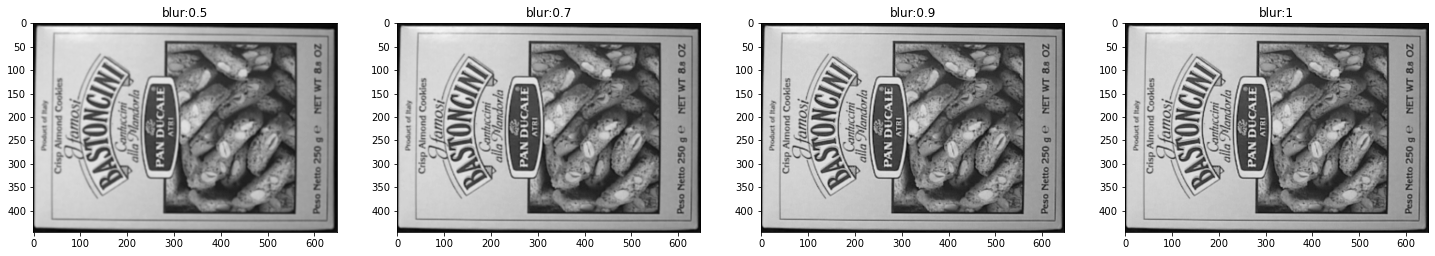

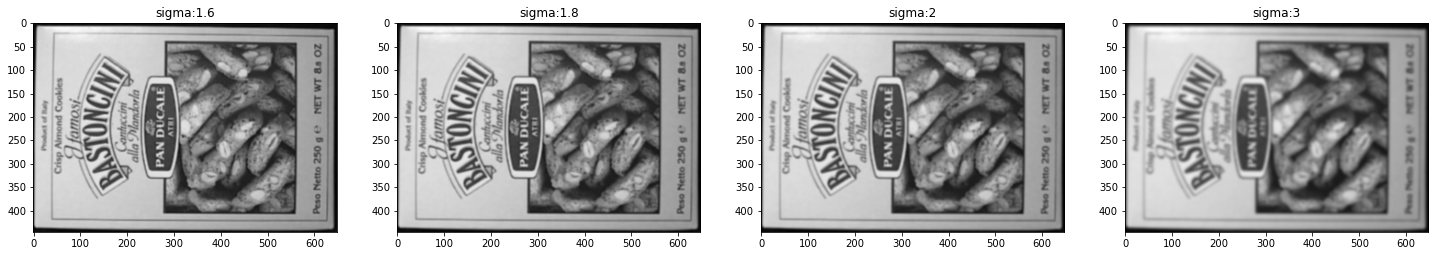

In [7]:
from pysift import *
img1 = cv2.imread('box.png', 0)           # queryImage
assumed_blurlist = [0.5, 0.7, 0.9, 1]
simaglist = [1.6, 1.8, 2, 3]

L = len(assumed_blurlist)

plt.figure(figsize=(25, 10))
print("generateBaseImage, fix sigma, adjust blurlist")
for idx, assumed_blur_iter in enumerate(assumed_blurlist):
    base_image = generateBaseImage(img1, sigma=1.6, assumed_blur=assumed_blur_iter)
    plt.subplot(L//3, 4, idx+1)
    plt.title(f"blur:{assumed_blur_iter}")
    plt.imshow(base_image, cmap="gray")


plt.figure(figsize=(25, 10))
print("generateBaseImage, adjust sigma, fix blur")
for idx, sigma_iter in enumerate(simaglist):
    base_image = generateBaseImage(img1, sigma=sigma_iter, assumed_blur=0.5)
    plt.subplot(L//3, 4, idx+1)
    plt.title(f"sigma:{sigma_iter}")
    plt.imshow(base_image, cmap="gray")

In [8]:
num_octaves = computeNumberOfOctaves(base_image.shape)
print(f"The number of octave: {num_octaves}")

The number of octave: 8


### Gaussian kernels

In [9]:
gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
gaussian_kernels

array([3.6       , 2.31693931, 2.75532071, 3.276647  , 3.89661192,
       4.63387862, 5.51064143])

In [10]:
num_intervals

4

(8, 7)


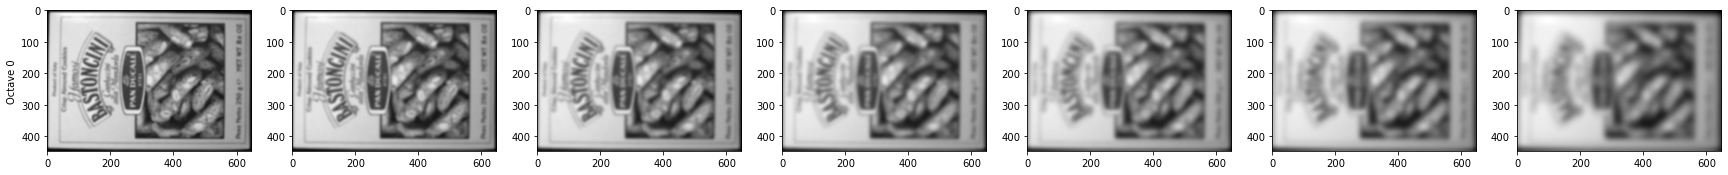

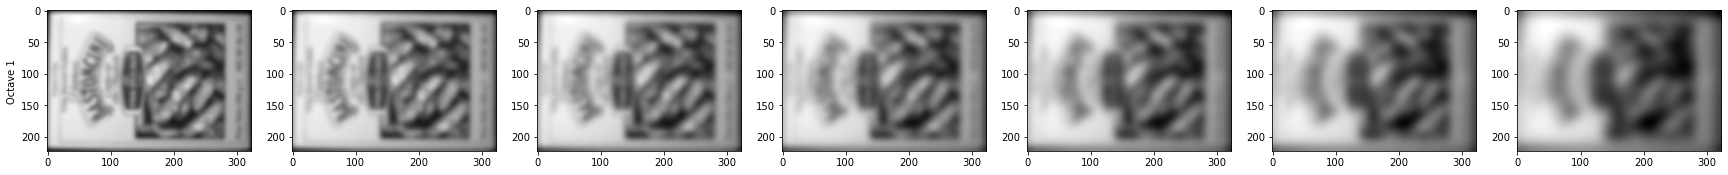

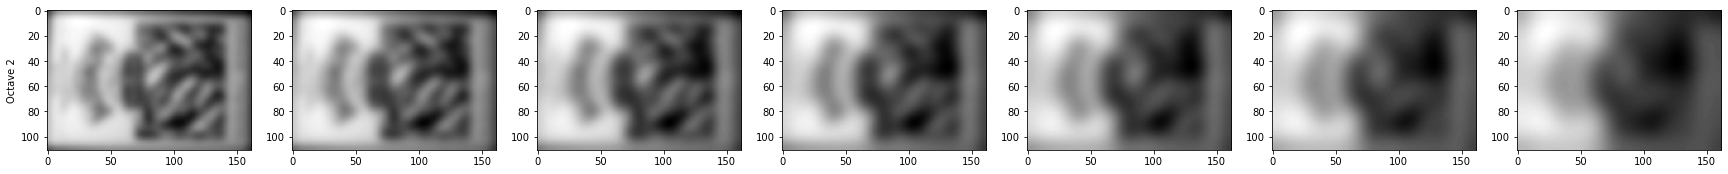

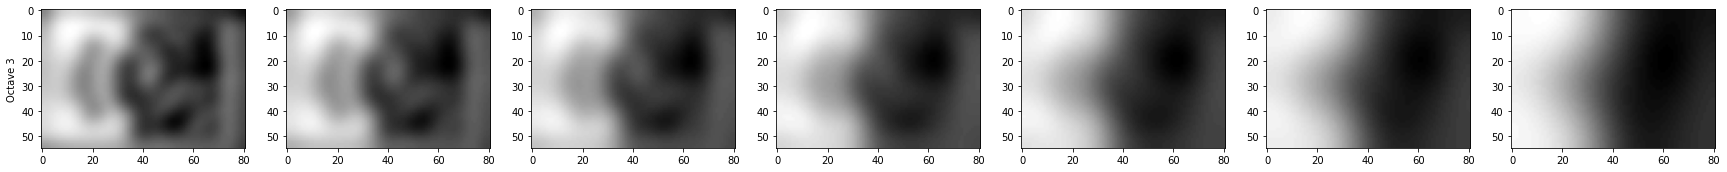

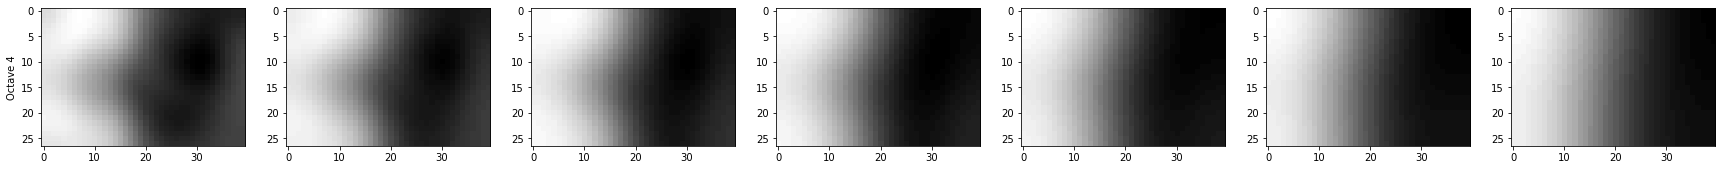

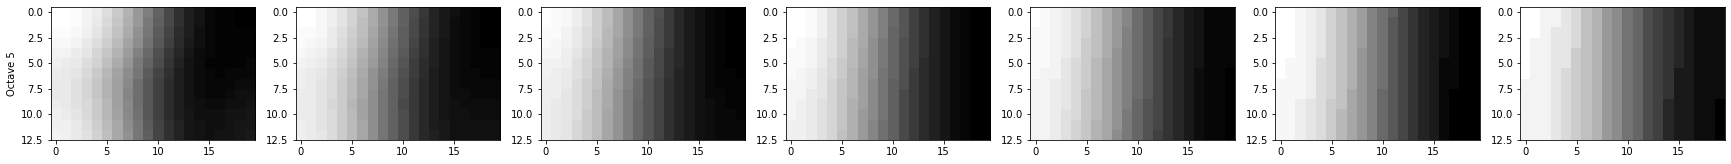

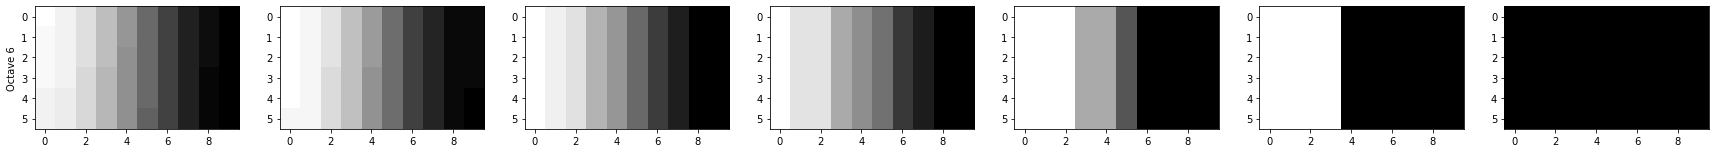

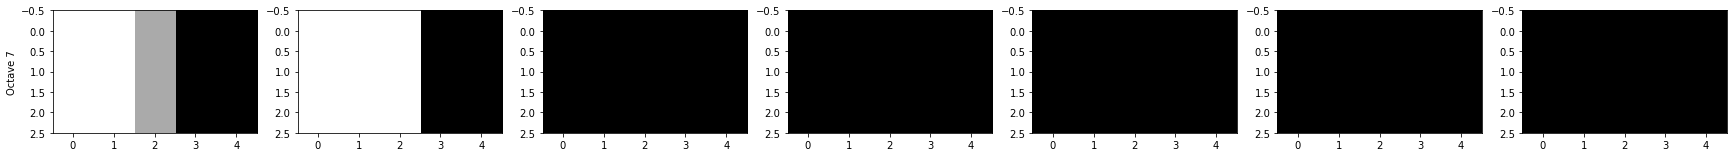

In [11]:
gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
print(gaussian_images.shape)
for octavenum, scale in enumerate(gaussian_images):
    plt.figure(figsize=(30, 16))
    for ctr, gimg in enumerate(scale):
        plt.subplot(1, num_intervals+3, ctr+1)
        plt.imshow(gimg, cmap="gray")
        # plt.axis("off")
        if ctr==0:
            plt.ylabel(f"Octave {octavenum}")
# plt.imshow(gaussian_images[0][0], cmap="gray")

### Difference of Gaussian mapping feature (DoG):
- To approximate the laplacian of the gaussion 

In [12]:
dog_images = generateDoGImages(gaussian_images)

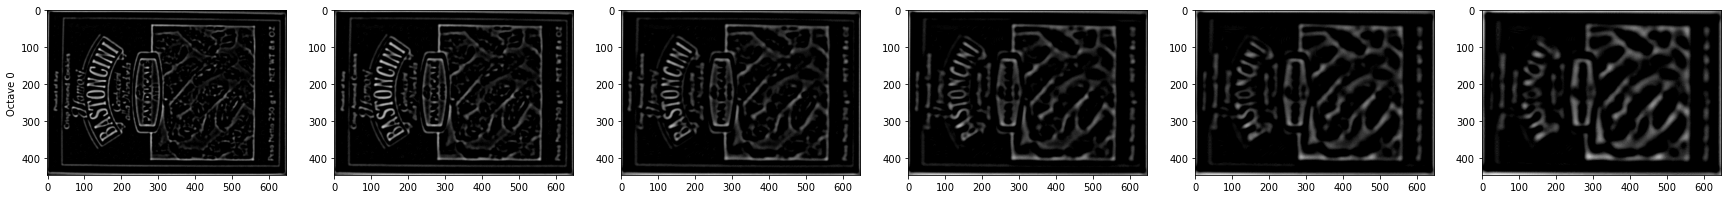

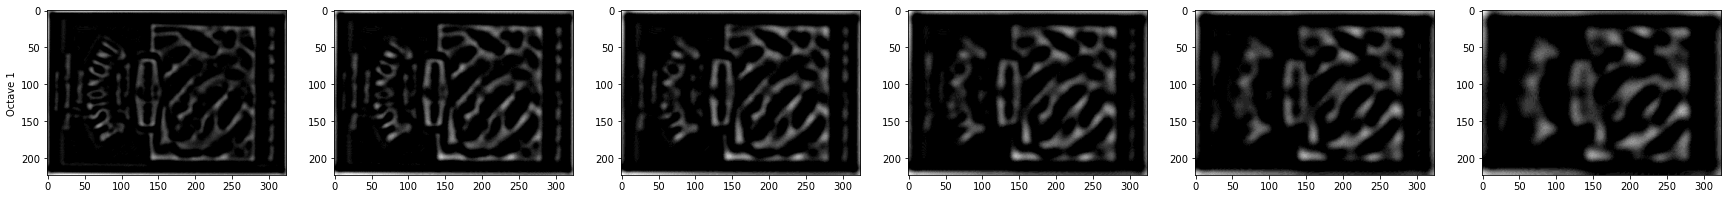

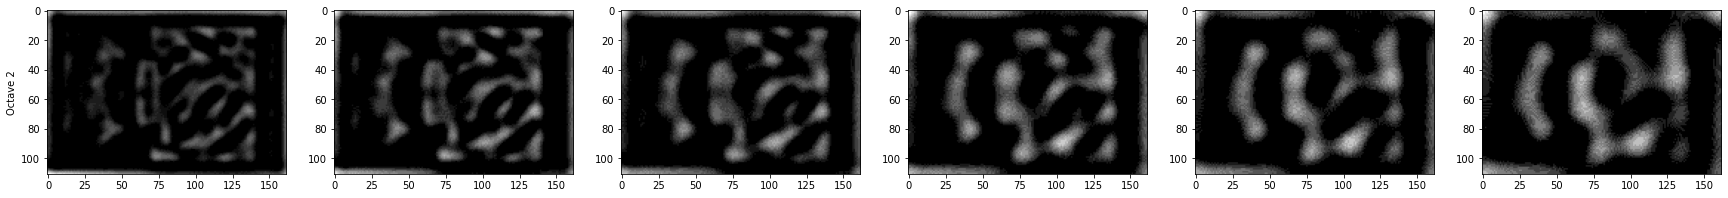

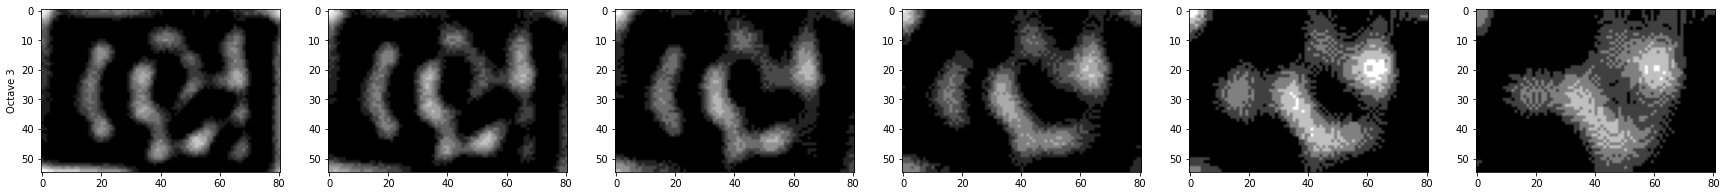

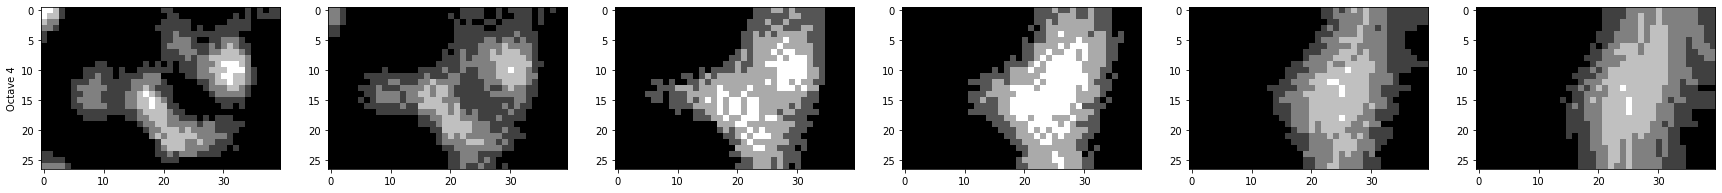

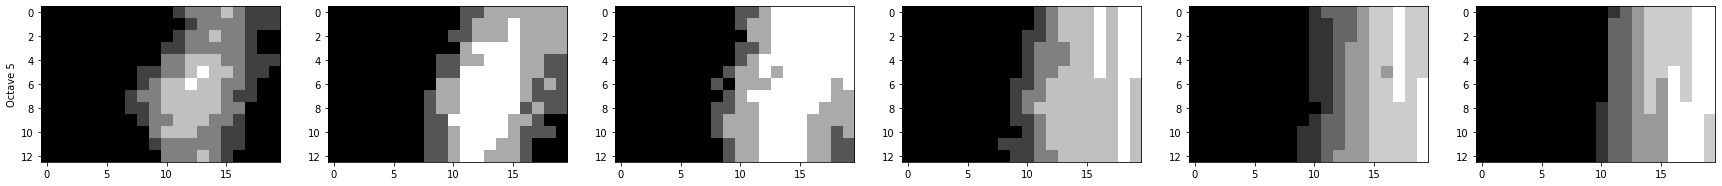

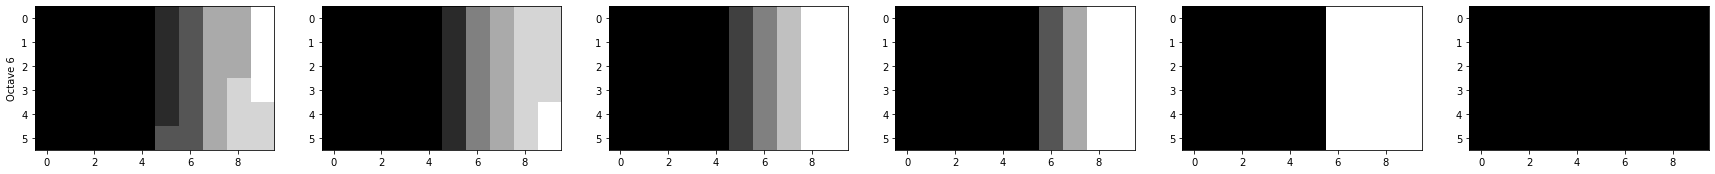

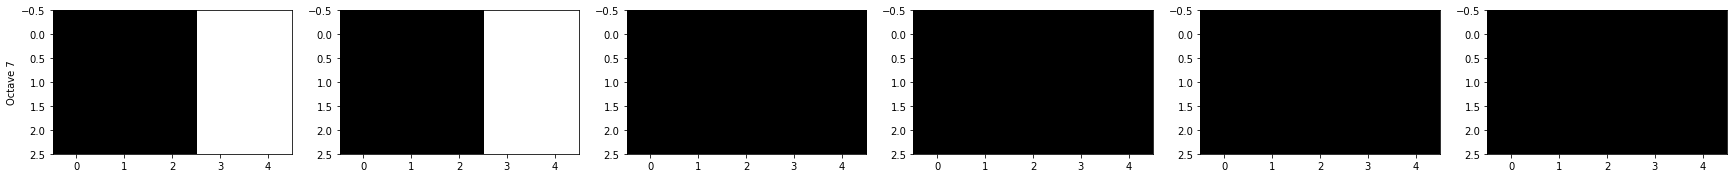

In [13]:
for octavenum, dogscale in enumerate(dog_images):
    plt.figure(figsize=(30, 16))
    for ctr, dogimg in enumerate(dogscale):
        plt.subplot(1, num_intervals+2, ctr+1)
        plt.imshow(dogimg, cmap="gray")
        # plt.axis("off")
        if ctr==0:
            plt.ylabel(f"Octave {octavenum}")
# plt.imshow(gaussian_images[0][0], cmap="gray")

### findScaleSpaceExtrema

In [14]:
floor(0.5 * 0.04 / 4 * 255)

1.0

他教會我讀 cv2.Keypoint location  
https://stackoverflow.com/questions/35884409/how-to-extract-x-y-coordinates-from-opencv-cv2-keypoint-object

### removeDuplicateKeypoints
- It's too many kypoint to compute.
- remove something is duplicate

In [21]:
keypoints = kp1
rmkeypoints = removeDuplicateKeypoints(keypoints)
print(f"Number of keypoints after removal: {len(rmkeypoints)}")
kploc = [kpt.pt for kpt in rmkeypoints]

Number of keypoints after removal: 133


In [22]:
for ctr, keypoint in enumerate(keypoints):
    print((keypoint.octave & ~255) | ((keypoint.octave - 1) & 255),
          (keypoint.octave - 1) & 255,
          (keypoint.octave & ~255),
          (keypoint.octave - 1), 
          (keypoint.octave >> 8))
    if ctr>10:
        break

7209726 254 7209472 7209726 28162
15860734 254 15860480 15860734 61955
15860734 254 15860480 15860734 61955
6226943 255 6226688 6226687 24323
4522494 254 4522240 4522494 17665
4522494 254 4522240 4522494 17665
9831422 254 9831168 9831422 38403
2818558 254 2818304 2818558 11009
2818558 254 2818304 2818558 11009
12911102 254 12910848 12911102 50433
15795198 254 15794944 15795198 61699
8848382 254 8848128 8848382 34563
